# R3-Tool_HW



## 非程式題

請前往 https://mcp.so/ ，選擇一個 MCP Server，並回答以下問題：

### 1. 該 MCP Server 的名稱為何？
> Enhance Prompt

### 2. 它提供了哪些主要功能？

> 接受簡單的關鍵字、短語或初始簡短提示，並將其增強為詳細、高品質的提示。此工具透過添加結構、上下文和具體性來提升最低限度的輸入，將基本想法轉化為有效的提示，並進行最佳化，以便從 AI 模型中產生更好、更可預測的結果。


### 3. 你認為這些功能可以應用於哪些實際場景或解決哪些問題？
> Magic Prompt, 在接受User問題時，快速進行高階意圖轉換

## 程式題
### baseline

使用 LangChain 的 Agent，註冊三個工具（查天氣、查時間、查匯率），讓 Agent 根據輸入自動選擇正確的工具來回答問題。

In [1]:
%%capture --no-stderr
!pip install -U langgraph langchain_openai==0.3.15 langchain transformers bitsandbytes langchain-huggingface langchain_core pydantic

In [2]:
import os
from typing import Annotated,List, Optional
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore
from langchain_openai import ChatOpenAI
from langchain_core.messages import trim_messages
from pydantic import BaseModel

In [5]:
from google.colab import userdata

In [6]:
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ['OPENAI_API_BASE'] = userdata.get('OPENAI_API_BASE')

In [ ]:
!pip install -U langchain_community

In [57]:
from langchain_community.chat_models import ChatOpenAI
from langchain.agents import initialize_agent, AgentType, Tool, load_tools
from langchain.tools import tool
import datetime

In [58]:
def get_weather(location: str) -> str:
  """查詢指定地點的天氣。location 是地點，date 是日期（格式：YYYY-MM-DD，可選）"""
  return f"{location} 今天天氣晴，溫度約 25°C。"

def get_time(location: str) -> str:
  """查詢指定地點當下的時間。location 是地點"""
  return f"{location} 現在時間是下午 3:00。"


def get_exchange_rate(currency: str) -> str:
  """查詢指定幣種的匯率。currency 是幣種"""
  if currency.upper() == "USD":
      return "1 USD = 31.25 TWD"
  elif currency.upper() == "JPY":
      return "1 JPY = 0.22 TWD"
  else:
      return f"{currency.upper()} 匯率資料暫無法提供"

In [60]:
tools = [
    Tool(
        name="get_weather",
        func=get_weather,
        description="查詢指定地點的天氣。location 是地點，date 是日期（格式：YYYY-MM-DD，可選）"
    ),
    Tool(
        name="get_time",
        func=get_time,
        description="查詢指定地點當下的時間。location 是地點"
    ),
    Tool(
        name="get_exchange_rate",
        func=get_exchange_rate,
        description="查詢指定幣種的匯率。currency 是幣種"
    )
]

In [61]:
MODEL = "meta-llama/llama-3.3-70b-instruct:free"

In [64]:
llm = ChatOpenAI(model=MODEL, base_url="https://openrouter.ai/api/v1")
#llm_with_tools = llm.bind_tools(tools)

In [65]:
# 3️⃣ 準備 system prompt，告訴模型「今天日期」
today_str = datetime.date.today().isoformat()
system_prompt = (
    f"今天日期是 {today_str}。在理解使用者提到的『今天、明天、後天』等相對日期時，"
    "請以此日期為基準並回覆具體的 YYYY-MM-DD。"
)

# 4️⃣ 初始化 Agent，透過 agent_kwargs 傳入 system prompt
agent = initialize_agent(
    tools=[get_weather],
    llm=llm,
    agent=AgentType.OPENAI_FUNCTIONS,
    agent_kwargs={"system_message": system_prompt},
    verbose=True          # 打開詳盡日誌，方便觀察工具呼叫
)


AttributeError: 'function' object has no attribute 'get'

In [29]:
# 5️⃣ 啟動 Agent：模型會用 system prompt 為基準，自動呼叫工具並回覆
response = agent.run("我想知道後天高雄的天氣")
print(response)



> Entering new AgentExecutor chain...


BadRequestError: Error code: 400 - {'error': {'message': '"functions" and "function_call" are deprecated in favor of "tools" and "tool_choice." To learn how to use tools, visit: https://openrouter.ai/docs/requests#tool-calls', 'code': 400, 'metadata': {'provider_name': 'Chutes'}}, 'user_id': 'user_2w9gBJLw3SzVow6vIHt7E17gtjY'}

## Advanced
使用LangGraph建立一個流程，由llm判斷問題是否與哆啦A夢道具相關，若有則使用RAG在資料庫裡找尋相關資料，若無則由模型自行回答問題。

Hint:參考流程圖

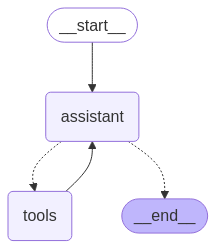

In [ ]:
docs_text = """
道具名稱	功能
引路天使	它可以告訴你最好的路，不至於在路上出意外。
雲朵凝固瓦斯	使用這個瓦斯的話，雲會凝固，變得可以奔走在雲上。
交換繩	兩人同時握住繩索的話，心還是一樣，但身體替換。
室內旅行機	可以顯示出各種地點的立體影像，但室內面積並不會隨之更動。會讓自己的家有旅行的味道。
落難神明	是一個難看老機器人。不過，幫助他的話，可以滿足3個請求。
南北極徽章	只要將自己與另外一個人貼上寫有「Ｎ」或「Ｓ」的徽章，就會變的像磁鐵一樣，同極相斥，異極相吸。
間諜工具組合	能用監視器看間諜人偶的「麥克風」和「」偵察的影像。
聲音糖果	只要利用這個錄製聲音，再給別人吃下去以後， 就可以得到被錄製聲音的特徵。
進化退化放射線槍	被這光照射到，動物就可以進化(或是退化)。
算了算了棒	用這個棒子將正在生氣的人的嘴巴堵住，並說「算了，算了」，那人氣就消了。
助興樂團	這兩個道具都是人型玩偶，都會播放音樂，讓氣氛變好；不同的是，只要讓小型插秧姑娘唱歌，就可以快速地完成插秧。
四次元口袋	哆啦A夢的道具都是放在這裡面的。四次元空間是個沒有大小的空間，要多大有多大。
美食桌巾	它可以幫你做出好吃的料理。無論甚麼料理都可以變出來。
愛神之箭	被箭射中的人，會對射箭的人產生好感。
感動麥克風	使用這個麥克風，發出的聲音就會讓人感動不已。
桃太郎丸子	讓動物吃下，他會對你言聽計從。
樵夫之泉	把東西丟到這個泉裡，女神就會出現。如果你說了實話，他就會給你一個更好、更新的東西。
更衣照相機	選擇合適的衣服，拍攝一下馬上就能穿在身上。
穿透環	可以穿過任何障礙。
如果電話亭	「如果這個世界是……」只要這樣對著話筒說話，就可以創造出你所說出的世界。但是當取消時，世界將會變成「平行世界」，雙方沒有瓜葛。
翻譯蒟蒻	吃了這個蒟蒻，任何人說的任何話，我們都可以聽懂、而且可以溝通。
縮小燈	被光照射到，東西會變小。
記憶麵包	只要吃下這個吐司，就能非常容易的記住事前寫在吐司上的事物。
時光布	包了的東西既可以變新，也可以變舊。
竹蜻蜓	是最常被哆啦A夢使用的道具！只要把它放置在身體任何部分，就可依自己意思在天空中翱翔。內藏超小型電池，可時速 80 公里連續飛行 8 小時。若是間斷飛行，還可撐更久！
時光機	除了時間移動之外，它也可以用來空間與空間間的互相移動。
任意門	只要心中想著想去的地點，電腦就會傳達並歪曲所在地與目的地間的空間而將兩地靠攏，跨過門就可以到達。但是不能去距離十光年以上的行星，或者是電腦地圖上沒有的地區。是很常用的道具，使用率位列第三，僅次於竹蜻蜓、時光機。

"""

In [ ]:
|